In [1]:
import torchvision
import torch
from torchvision import models
from torchvision import transforms
from torchvision import utils
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import itertools
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset
import matplotlib.pyplot as plt

In [2]:
img_size = 28
num_batches = 64
learning_rate = 0.0002
transform = transforms.Compose([
    transforms.Scale(img_size),
    transforms.ToTensor(),
    transforms.Normalize((.5,), (.5,))
])


C:\Users\april\Anaconda3\lib\site-packages\torchvision\transforms\transforms.py:210: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [3]:
%matplotlib inline
fmnist = torchvision.datasets.FashionMNIST(root="./", train=True,
transform=transform, download=True)
data_loader = torch.utils.data.DataLoader(dataset=fmnist,
batch_size=64, shuffle=True)

In [4]:
#https://medium.com/ai-society/gans-from-scratch-1-a-deep-introduction-with-code-in-pytorch-and-tensorflow-cb03cdcdba0f
class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 784
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
discriminator = DiscriminatorNet()

In [5]:
def images_to_vectors(images):
    return images.view(images.size(0), 784)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)

In [6]:
class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = 784
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
    
# Noise
def noise(size):
    n = Variable(torch.randn(size, 100))
    if torch.cuda.is_available(): return n.cuda() 
    return n

In [7]:
discriminator = DiscriminatorNet()
generator = GeneratorNet()
if torch.cuda.is_available():
    discriminator.cuda()
    generator.cuda()

In [8]:
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

In [16]:
MSEloss =nn.MSELoss()

In [10]:
def real_data_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

def fake_data_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

In [11]:
def train_discriminator(optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = MSEloss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = MSEloss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error
    return error_real + error_fake, prediction_real, prediction_fake

def train_generator(optimizer, fake_data):
    # 2. Train Generator
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = MSEloss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

In [12]:
num_test_samples = 16
test_noise = noise(num_test_samples)

# run logger class at the end first

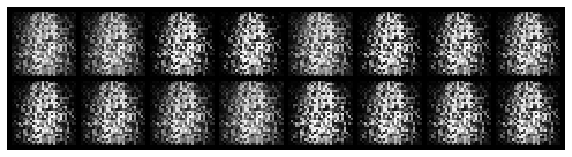

2020-04-30 20:20:13.781319 Epoch: [0/100], Batch Num: [0/64]
Discriminator Loss: 1.0000, Generator Loss: 0.0000
D(x): 0.9998, D(G(z)): 1.0000


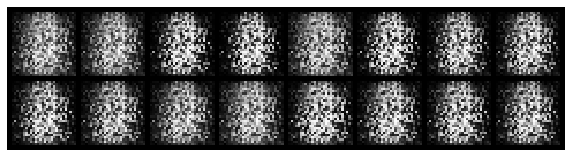

2020-04-30 20:20:38.620151 Epoch: [1/100], Batch Num: [0/64]
Discriminator Loss: 0.0173, Generator Loss: 0.9141
D(x): 0.9296, D(G(z)): 0.0298


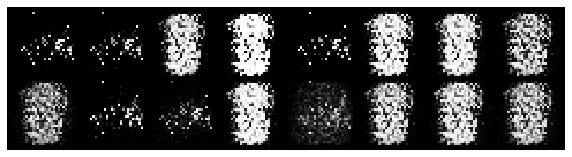

2020-04-30 20:21:03.497273 Epoch: [2/100], Batch Num: [0/64]
Discriminator Loss: 0.1339, Generator Loss: 0.9193
D(x): 0.8698, D(G(z)): 0.0804


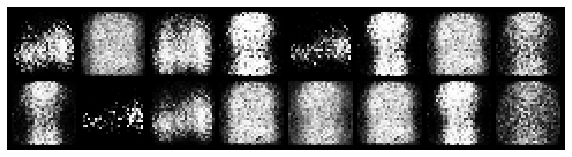

2020-04-30 20:21:28.201290 Epoch: [3/100], Batch Num: [0/64]
Discriminator Loss: 0.4252, Generator Loss: 0.5776
D(x): 0.7834, D(G(z)): 0.4689


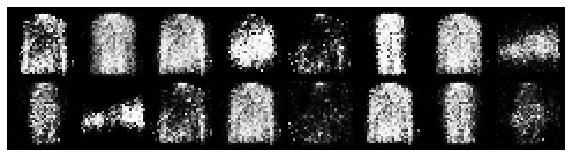

2020-04-30 20:21:53.010506 Epoch: [4/100], Batch Num: [0/64]
Discriminator Loss: 0.3206, Generator Loss: 0.6751
D(x): 0.6734, D(G(z)): 0.2802


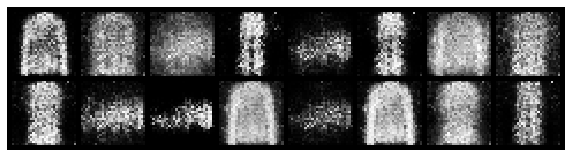

2020-04-30 20:22:18.009928 Epoch: [5/100], Batch Num: [0/64]
Discriminator Loss: 0.2663, Generator Loss: 0.6813
D(x): 0.7308, D(G(z)): 0.2676


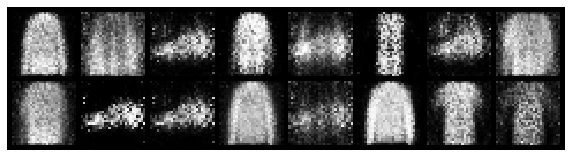

2020-04-30 20:22:42.873447 Epoch: [6/100], Batch Num: [0/64]
Discriminator Loss: 0.4654, Generator Loss: 0.4963
D(x): 0.5750, D(G(z)): 0.3887


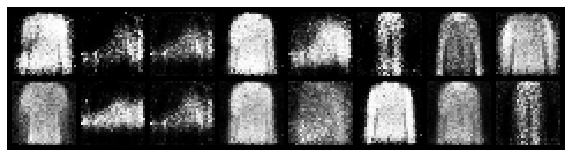

2020-04-30 20:23:07.890015 Epoch: [7/100], Batch Num: [0/64]
Discriminator Loss: 0.4467, Generator Loss: 0.5190
D(x): 0.6551, D(G(z)): 0.4248


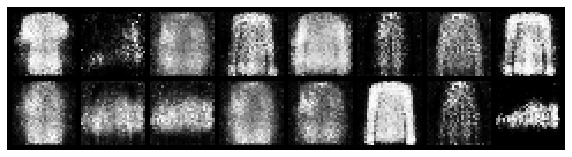

2020-04-30 20:23:32.678516 Epoch: [8/100], Batch Num: [0/64]
Discriminator Loss: 0.4136, Generator Loss: 0.4915
D(x): 0.6192, D(G(z)): 0.3552


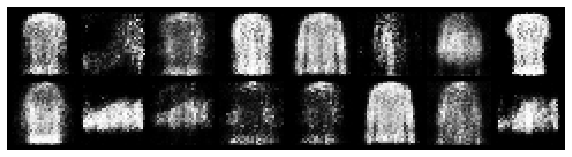

2020-04-30 20:23:57.406416 Epoch: [9/100], Batch Num: [0/64]
Discriminator Loss: 0.4182, Generator Loss: 0.4798
D(x): 0.6060, D(G(z)): 0.4241


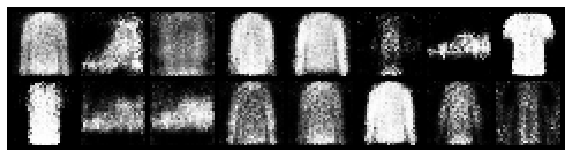

2020-04-30 20:24:22.868531 Epoch: [10/100], Batch Num: [0/64]
Discriminator Loss: 0.3920, Generator Loss: 0.4445
D(x): 0.6844, D(G(z)): 0.4146


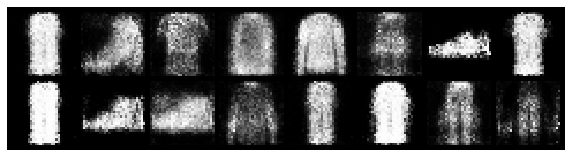

2020-04-30 20:24:47.468626 Epoch: [11/100], Batch Num: [0/64]
Discriminator Loss: 0.4039, Generator Loss: 0.4803
D(x): 0.6815, D(G(z)): 0.4133


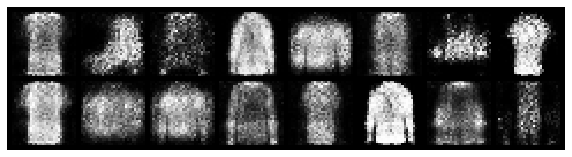

2020-04-30 20:25:12.026590 Epoch: [12/100], Batch Num: [0/64]
Discriminator Loss: 0.4121, Generator Loss: 0.4147
D(x): 0.5715, D(G(z)): 0.3684


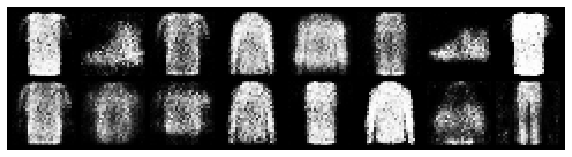

2020-04-30 20:25:36.988003 Epoch: [13/100], Batch Num: [0/64]
Discriminator Loss: 0.4701, Generator Loss: 0.4341
D(x): 0.6089, D(G(z)): 0.4293


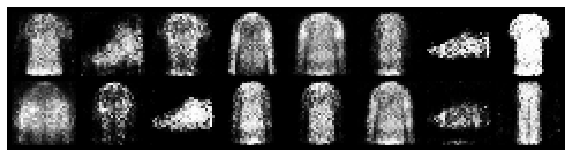

2020-04-30 20:26:01.791043 Epoch: [14/100], Batch Num: [0/64]
Discriminator Loss: 0.3636, Generator Loss: 0.5624
D(x): 0.5621, D(G(z)): 0.3126


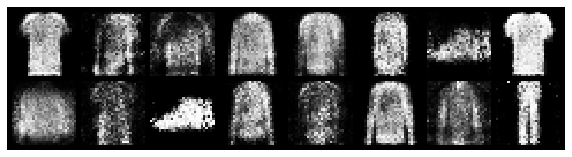

2020-04-30 20:26:26.496434 Epoch: [15/100], Batch Num: [0/64]
Discriminator Loss: 0.3971, Generator Loss: 0.4986
D(x): 0.5603, D(G(z)): 0.3427


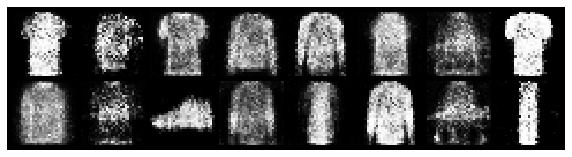

2020-04-30 20:26:51.122417 Epoch: [16/100], Batch Num: [0/64]
Discriminator Loss: 0.4543, Generator Loss: 0.5281
D(x): 0.5609, D(G(z)): 0.3756


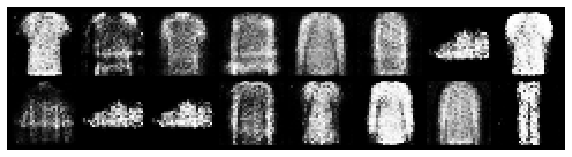

2020-04-30 20:27:15.901133 Epoch: [17/100], Batch Num: [0/64]
Discriminator Loss: 0.3382, Generator Loss: 0.4512
D(x): 0.6657, D(G(z)): 0.3737


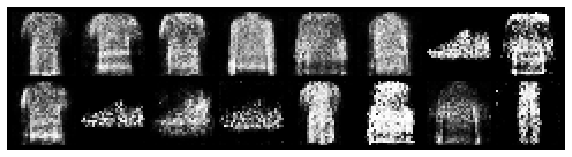

2020-04-30 20:27:40.459032 Epoch: [18/100], Batch Num: [0/64]
Discriminator Loss: 0.3503, Generator Loss: 0.5792
D(x): 0.6612, D(G(z)): 0.3187


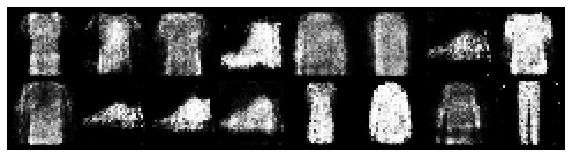

2020-04-30 20:28:04.785219 Epoch: [19/100], Batch Num: [0/64]
Discriminator Loss: 0.3616, Generator Loss: 0.4523
D(x): 0.6209, D(G(z)): 0.3739


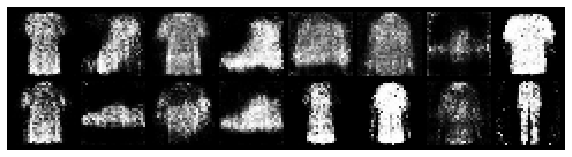

2020-04-30 20:28:29.216524 Epoch: [20/100], Batch Num: [0/64]
Discriminator Loss: 0.3738, Generator Loss: 0.5194
D(x): 0.5985, D(G(z)): 0.3267


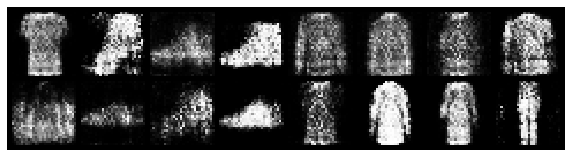

2020-04-30 20:28:53.667049 Epoch: [21/100], Batch Num: [0/64]
Discriminator Loss: 0.3142, Generator Loss: 0.5269
D(x): 0.7112, D(G(z)): 0.3489


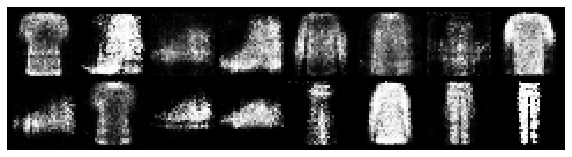

2020-04-30 20:29:18.155657 Epoch: [22/100], Batch Num: [0/64]
Discriminator Loss: 0.3668, Generator Loss: 0.4409
D(x): 0.6255, D(G(z)): 0.3247


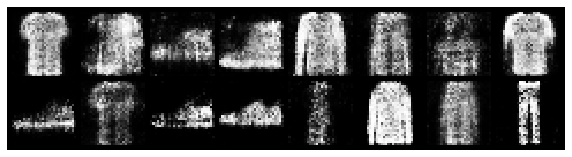

2020-04-30 20:29:42.498708 Epoch: [23/100], Batch Num: [0/64]
Discriminator Loss: 0.3540, Generator Loss: 0.4280
D(x): 0.6311, D(G(z)): 0.3430


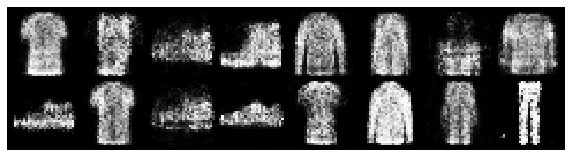

2020-04-30 20:30:06.822859 Epoch: [24/100], Batch Num: [0/64]
Discriminator Loss: 0.4482, Generator Loss: 0.3858
D(x): 0.5640, D(G(z)): 0.4095


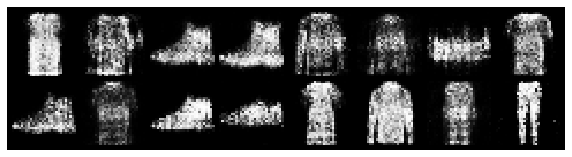

2020-04-30 20:30:31.132244 Epoch: [25/100], Batch Num: [0/64]
Discriminator Loss: 0.4389, Generator Loss: 0.3554
D(x): 0.6054, D(G(z)): 0.4530


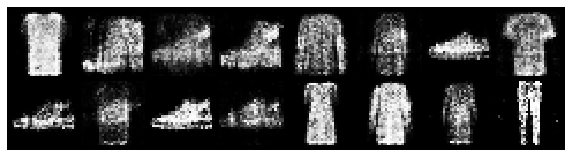

2020-04-30 20:30:55.438841 Epoch: [26/100], Batch Num: [0/64]
Discriminator Loss: 0.4499, Generator Loss: 0.4677
D(x): 0.5687, D(G(z)): 0.3767


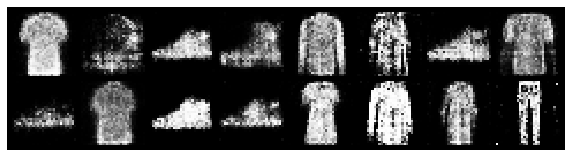

2020-04-30 20:31:19.723451 Epoch: [27/100], Batch Num: [0/64]
Discriminator Loss: 0.3416, Generator Loss: 0.4376
D(x): 0.6335, D(G(z)): 0.3578


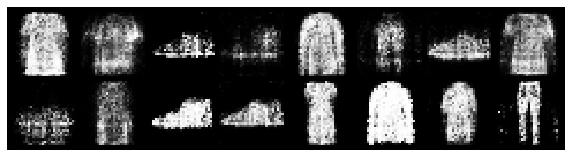

2020-04-30 20:31:44.221941 Epoch: [28/100], Batch Num: [0/64]
Discriminator Loss: 0.3934, Generator Loss: 0.4938
D(x): 0.6124, D(G(z)): 0.3846


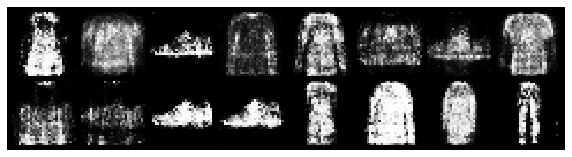

2020-04-30 20:32:08.543560 Epoch: [29/100], Batch Num: [0/64]
Discriminator Loss: 0.3553, Generator Loss: 0.4570
D(x): 0.7505, D(G(z)): 0.4257


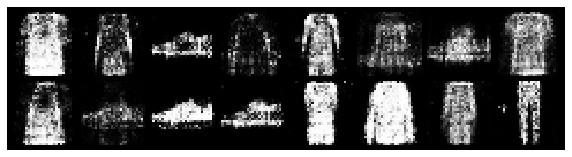

2020-04-30 20:32:32.864348 Epoch: [30/100], Batch Num: [0/64]
Discriminator Loss: 0.4397, Generator Loss: 0.4678
D(x): 0.6416, D(G(z)): 0.4270


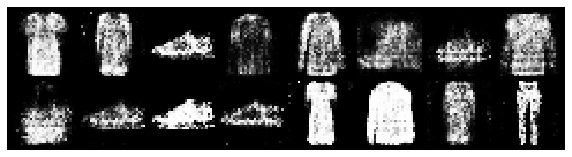

2020-04-30 20:32:57.207311 Epoch: [31/100], Batch Num: [0/64]
Discriminator Loss: 0.4039, Generator Loss: 0.4267
D(x): 0.6259, D(G(z)): 0.4048


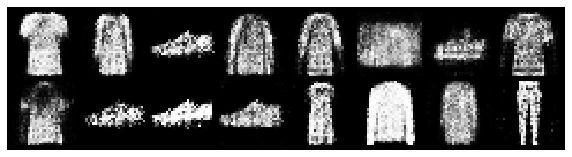

2020-04-30 20:33:21.605480 Epoch: [32/100], Batch Num: [0/64]
Discriminator Loss: 0.3878, Generator Loss: 0.4650
D(x): 0.5880, D(G(z)): 0.3489


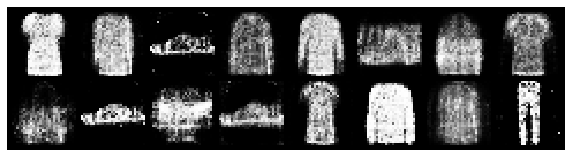

2020-04-30 20:33:45.957249 Epoch: [33/100], Batch Num: [0/64]
Discriminator Loss: 0.3688, Generator Loss: 0.4177
D(x): 0.6497, D(G(z)): 0.3830


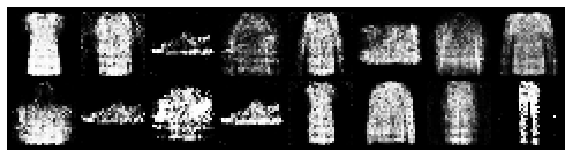

2020-04-30 20:34:10.320211 Epoch: [34/100], Batch Num: [0/64]
Discriminator Loss: 0.4874, Generator Loss: 0.4408
D(x): 0.5614, D(G(z)): 0.4057


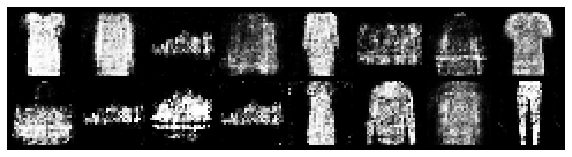

2020-04-30 20:34:34.749082 Epoch: [35/100], Batch Num: [0/64]
Discriminator Loss: 0.4181, Generator Loss: 0.3205
D(x): 0.6258, D(G(z)): 0.4462


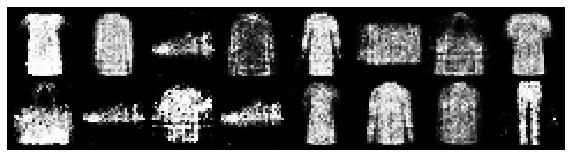

2020-04-30 20:34:59.162647 Epoch: [36/100], Batch Num: [0/64]
Discriminator Loss: 0.4218, Generator Loss: 0.4099
D(x): 0.5817, D(G(z)): 0.4053


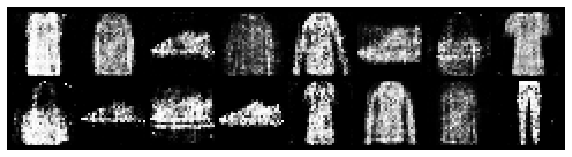

2020-04-30 20:35:23.593513 Epoch: [37/100], Batch Num: [0/64]
Discriminator Loss: 0.3753, Generator Loss: 0.3868
D(x): 0.6289, D(G(z)): 0.3801


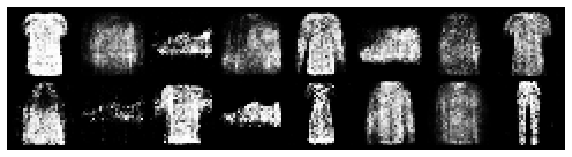

2020-04-30 20:35:48.067447 Epoch: [38/100], Batch Num: [0/64]
Discriminator Loss: 0.3971, Generator Loss: 0.4986
D(x): 0.5582, D(G(z)): 0.3500


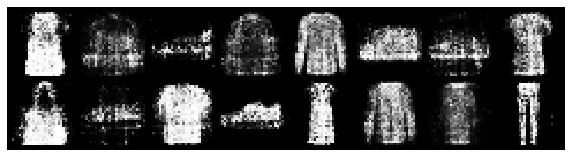

2020-04-30 20:36:12.356824 Epoch: [39/100], Batch Num: [0/64]
Discriminator Loss: 0.3962, Generator Loss: 0.4312
D(x): 0.6250, D(G(z)): 0.3771


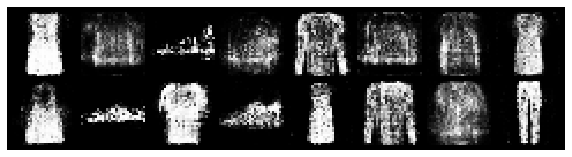

2020-04-30 20:36:36.630768 Epoch: [40/100], Batch Num: [0/64]
Discriminator Loss: 0.4205, Generator Loss: 0.4035
D(x): 0.6231, D(G(z)): 0.4384


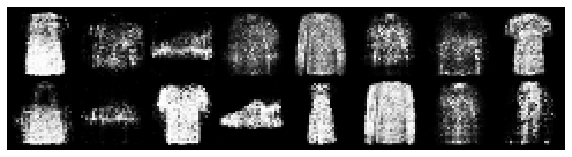

2020-04-30 20:37:00.997808 Epoch: [41/100], Batch Num: [0/64]
Discriminator Loss: 0.4203, Generator Loss: 0.3918
D(x): 0.5985, D(G(z)): 0.4071


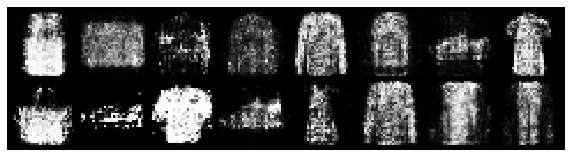

2020-04-30 20:37:25.355938 Epoch: [42/100], Batch Num: [0/64]
Discriminator Loss: 0.4557, Generator Loss: 0.4333
D(x): 0.6158, D(G(z)): 0.4194


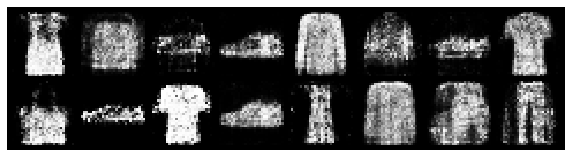

2020-04-30 20:37:49.215493 Epoch: [43/100], Batch Num: [0/64]
Discriminator Loss: 0.4041, Generator Loss: 0.5031
D(x): 0.5344, D(G(z)): 0.3281


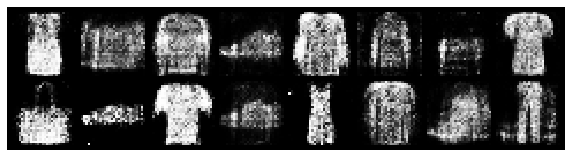

2020-04-30 20:38:12.666853 Epoch: [44/100], Batch Num: [0/64]
Discriminator Loss: 0.4354, Generator Loss: 0.3980
D(x): 0.6088, D(G(z)): 0.4368


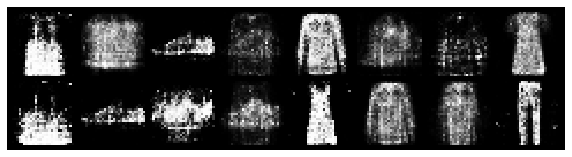

2020-04-30 20:38:36.081855 Epoch: [45/100], Batch Num: [0/64]
Discriminator Loss: 0.3871, Generator Loss: 0.4644
D(x): 0.6127, D(G(z)): 0.3774


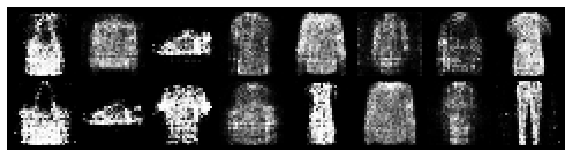

2020-04-30 20:38:59.509853 Epoch: [46/100], Batch Num: [0/64]
Discriminator Loss: 0.4173, Generator Loss: 0.4592
D(x): 0.6685, D(G(z)): 0.4540


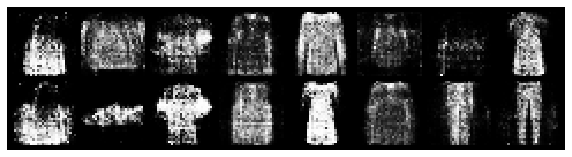

2020-04-30 20:39:23.021611 Epoch: [47/100], Batch Num: [0/64]
Discriminator Loss: 0.4386, Generator Loss: 0.3695
D(x): 0.5707, D(G(z)): 0.4009


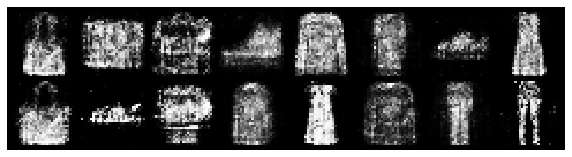

2020-04-30 20:39:46.476183 Epoch: [48/100], Batch Num: [0/64]
Discriminator Loss: 0.4466, Generator Loss: 0.5238
D(x): 0.5119, D(G(z)): 0.3095


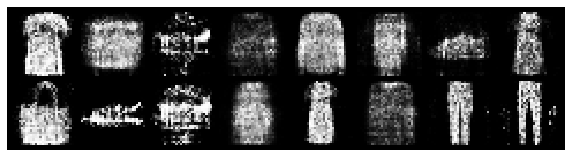

2020-04-30 20:40:09.888117 Epoch: [49/100], Batch Num: [0/64]
Discriminator Loss: 0.3918, Generator Loss: 0.3576
D(x): 0.6071, D(G(z)): 0.4252


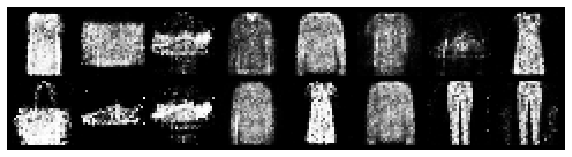

2020-04-30 20:40:33.322154 Epoch: [50/100], Batch Num: [0/64]
Discriminator Loss: 0.4398, Generator Loss: 0.3765
D(x): 0.5345, D(G(z)): 0.4092


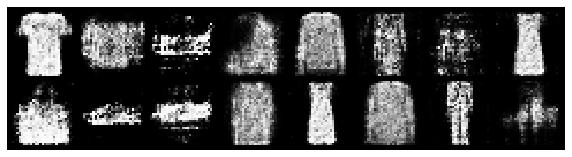

2020-04-30 20:40:56.796278 Epoch: [51/100], Batch Num: [0/64]
Discriminator Loss: 0.3685, Generator Loss: 0.3542
D(x): 0.6493, D(G(z)): 0.3891


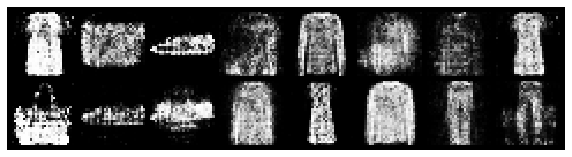

2020-04-30 20:41:20.217841 Epoch: [52/100], Batch Num: [0/64]
Discriminator Loss: 0.3906, Generator Loss: 0.4231
D(x): 0.6267, D(G(z)): 0.3950


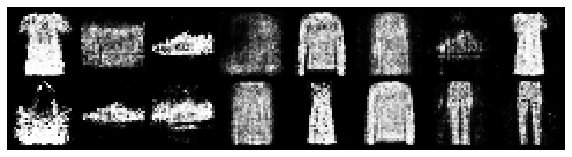

2020-04-30 20:41:43.657640 Epoch: [53/100], Batch Num: [0/64]
Discriminator Loss: 0.4023, Generator Loss: 0.4047
D(x): 0.5863, D(G(z)): 0.4038


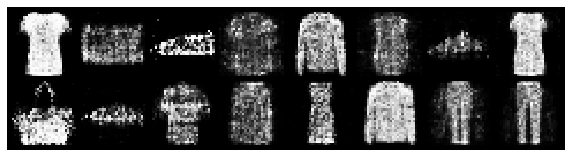

2020-04-30 20:42:07.132077 Epoch: [54/100], Batch Num: [0/64]
Discriminator Loss: 0.4736, Generator Loss: 0.3762
D(x): 0.5167, D(G(z)): 0.4080


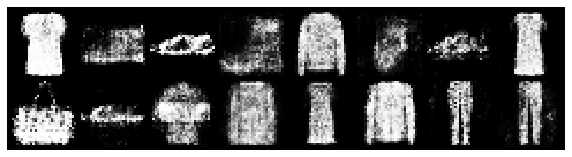

2020-04-30 20:42:30.536832 Epoch: [55/100], Batch Num: [0/64]
Discriminator Loss: 0.4719, Generator Loss: 0.3032
D(x): 0.5607, D(G(z)): 0.4563


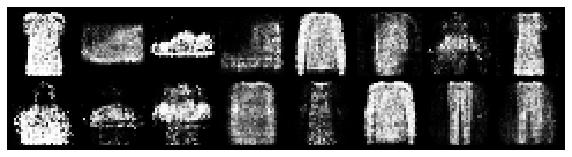

2020-04-30 20:42:54.066397 Epoch: [56/100], Batch Num: [0/64]
Discriminator Loss: 0.4693, Generator Loss: 0.4103
D(x): 0.5041, D(G(z)): 0.3823


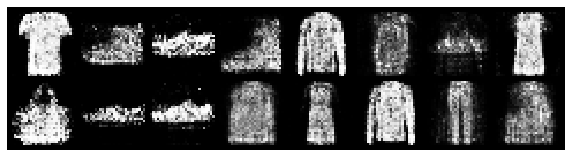

2020-04-30 20:43:17.471116 Epoch: [57/100], Batch Num: [0/64]
Discriminator Loss: 0.3851, Generator Loss: 0.4451
D(x): 0.6010, D(G(z)): 0.3700


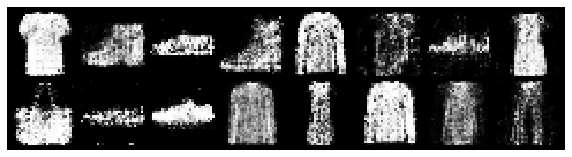

2020-04-30 20:43:41.087907 Epoch: [58/100], Batch Num: [0/64]
Discriminator Loss: 0.3948, Generator Loss: 0.3487
D(x): 0.6027, D(G(z)): 0.4238


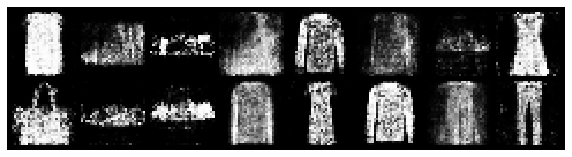

2020-04-30 20:44:04.543452 Epoch: [59/100], Batch Num: [0/64]
Discriminator Loss: 0.4225, Generator Loss: 0.4140
D(x): 0.6525, D(G(z)): 0.4502


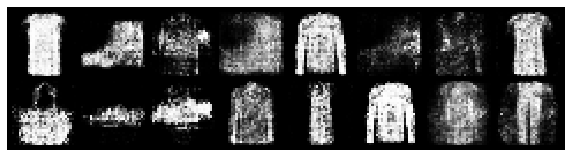

2020-04-30 20:44:28.066926 Epoch: [60/100], Batch Num: [0/64]
Discriminator Loss: 0.5242, Generator Loss: 0.3292
D(x): 0.5051, D(G(z)): 0.4705


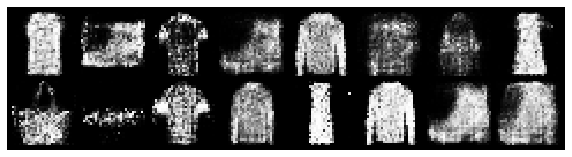

2020-04-30 20:44:51.502089 Epoch: [61/100], Batch Num: [0/64]
Discriminator Loss: 0.4125, Generator Loss: 0.4144
D(x): 0.5678, D(G(z)): 0.3793


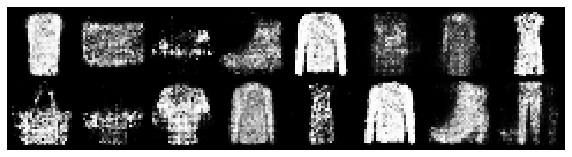

2020-04-30 20:45:14.945588 Epoch: [62/100], Batch Num: [0/64]
Discriminator Loss: 0.4188, Generator Loss: 0.3836
D(x): 0.5304, D(G(z)): 0.3736


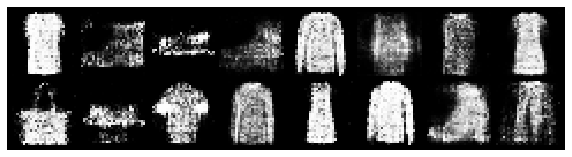

2020-04-30 20:45:38.337199 Epoch: [63/100], Batch Num: [0/64]
Discriminator Loss: 0.3780, Generator Loss: 0.5262
D(x): 0.6063, D(G(z)): 0.3467


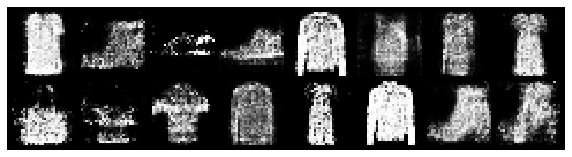

2020-04-30 20:46:01.740128 Epoch: [64/100], Batch Num: [0/64]
Discriminator Loss: 0.4004, Generator Loss: 0.3753
D(x): 0.5990, D(G(z)): 0.3895


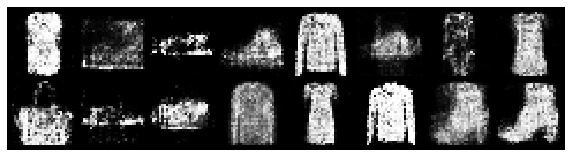

2020-04-30 20:46:25.116814 Epoch: [65/100], Batch Num: [0/64]
Discriminator Loss: 0.4464, Generator Loss: 0.3632
D(x): 0.5668, D(G(z)): 0.4409


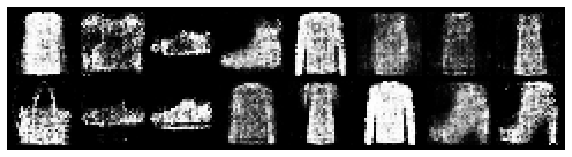

2020-04-30 20:46:48.567314 Epoch: [66/100], Batch Num: [0/64]
Discriminator Loss: 0.4101, Generator Loss: 0.3748
D(x): 0.5492, D(G(z)): 0.3740


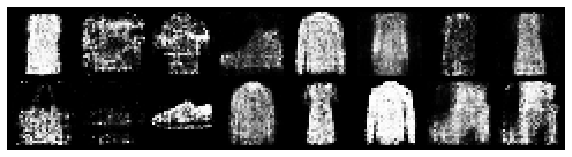

2020-04-30 20:47:11.984630 Epoch: [67/100], Batch Num: [0/64]
Discriminator Loss: 0.4135, Generator Loss: 0.3817
D(x): 0.6694, D(G(z)): 0.4580


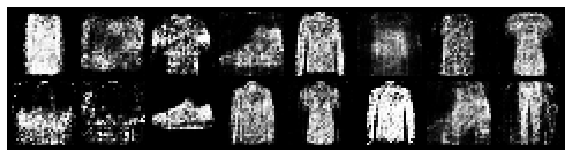

2020-04-30 20:47:35.460057 Epoch: [68/100], Batch Num: [0/64]
Discriminator Loss: 0.4271, Generator Loss: 0.4244
D(x): 0.5577, D(G(z)): 0.4039


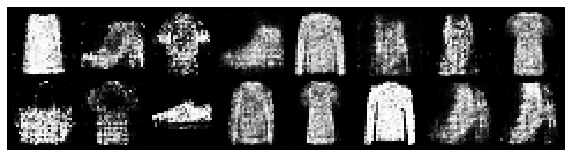

2020-04-30 20:47:59.022644 Epoch: [69/100], Batch Num: [0/64]
Discriminator Loss: 0.4586, Generator Loss: 0.4269
D(x): 0.5349, D(G(z)): 0.3865


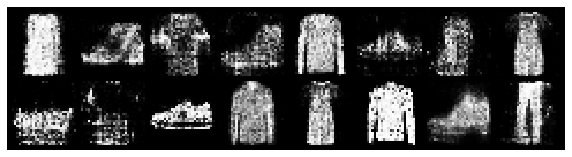

2020-04-30 20:48:22.507790 Epoch: [70/100], Batch Num: [0/64]
Discriminator Loss: 0.4506, Generator Loss: 0.3647
D(x): 0.5679, D(G(z)): 0.4070


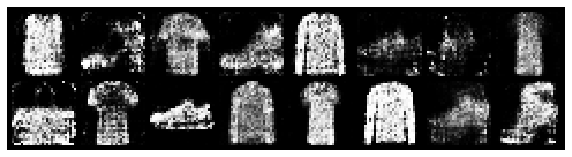

2020-04-30 20:48:45.980211 Epoch: [71/100], Batch Num: [0/64]
Discriminator Loss: 0.4473, Generator Loss: 0.3515
D(x): 0.5734, D(G(z)): 0.4634


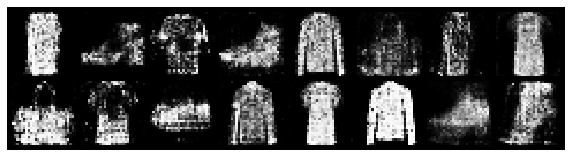

2020-04-30 20:49:09.453978 Epoch: [72/100], Batch Num: [0/64]
Discriminator Loss: 0.4585, Generator Loss: 0.4148
D(x): 0.6067, D(G(z)): 0.4233


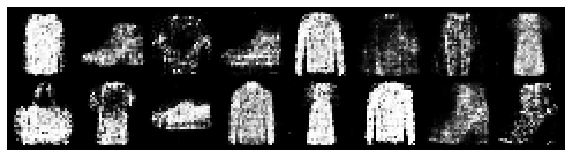

2020-04-30 20:49:32.979072 Epoch: [73/100], Batch Num: [0/64]
Discriminator Loss: 0.3761, Generator Loss: 0.3894
D(x): 0.5998, D(G(z)): 0.4043


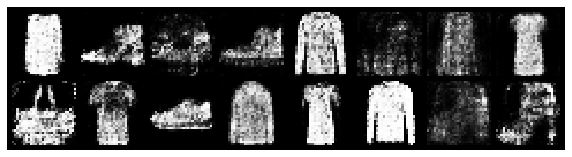

2020-04-30 20:49:56.353638 Epoch: [74/100], Batch Num: [0/64]
Discriminator Loss: 0.4868, Generator Loss: 0.4059
D(x): 0.5099, D(G(z)): 0.4032


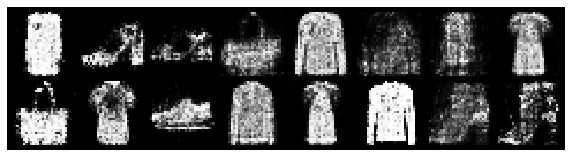

2020-04-30 20:50:19.963083 Epoch: [75/100], Batch Num: [0/64]
Discriminator Loss: 0.4377, Generator Loss: 0.3206
D(x): 0.6139, D(G(z)): 0.4410


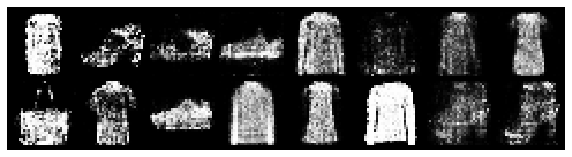

2020-04-30 20:50:43.436938 Epoch: [76/100], Batch Num: [0/64]
Discriminator Loss: 0.3544, Generator Loss: 0.3770
D(x): 0.6483, D(G(z)): 0.3987


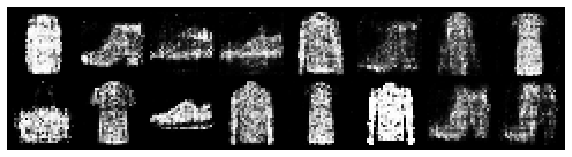

2020-04-30 20:51:06.970319 Epoch: [77/100], Batch Num: [0/64]
Discriminator Loss: 0.3669, Generator Loss: 0.5214
D(x): 0.6710, D(G(z)): 0.4172


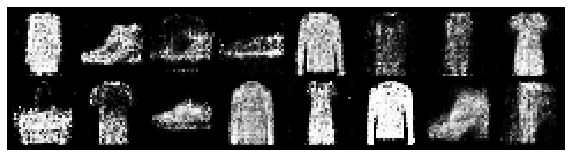

2020-04-30 20:51:30.432762 Epoch: [78/100], Batch Num: [0/64]
Discriminator Loss: 0.4866, Generator Loss: 0.4510
D(x): 0.5442, D(G(z)): 0.4240


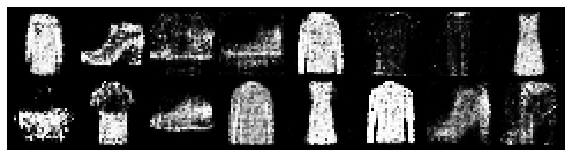

2020-04-30 20:51:53.909770 Epoch: [79/100], Batch Num: [0/64]
Discriminator Loss: 0.4786, Generator Loss: 0.3937
D(x): 0.5674, D(G(z)): 0.4482


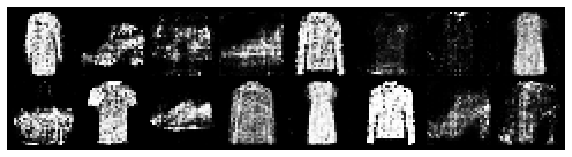

2020-04-30 20:52:17.408961 Epoch: [80/100], Batch Num: [0/64]
Discriminator Loss: 0.3920, Generator Loss: 0.3486
D(x): 0.5893, D(G(z)): 0.4174


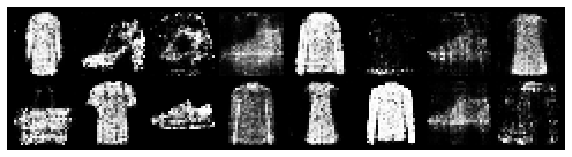

2020-04-30 20:52:40.993895 Epoch: [81/100], Batch Num: [0/64]
Discriminator Loss: 0.4561, Generator Loss: 0.3728
D(x): 0.5462, D(G(z)): 0.4290


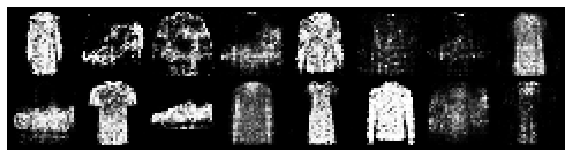

2020-04-30 20:53:04.535647 Epoch: [82/100], Batch Num: [0/64]
Discriminator Loss: 0.3983, Generator Loss: 0.4003
D(x): 0.5638, D(G(z)): 0.3898


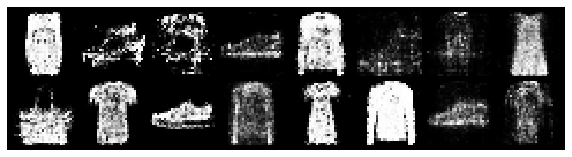

2020-04-30 20:53:28.024123 Epoch: [83/100], Batch Num: [0/64]
Discriminator Loss: 0.3767, Generator Loss: 0.4817
D(x): 0.6626, D(G(z)): 0.3705


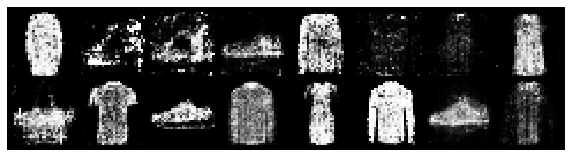

2020-04-30 20:53:51.520084 Epoch: [84/100], Batch Num: [0/64]
Discriminator Loss: 0.4381, Generator Loss: 0.3154
D(x): 0.5983, D(G(z)): 0.4309


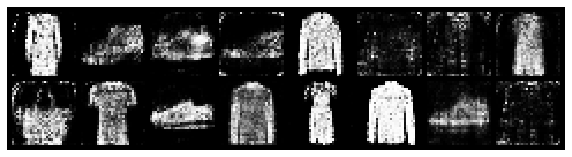

2020-04-30 20:54:14.996761 Epoch: [85/100], Batch Num: [0/64]
Discriminator Loss: 0.4331, Generator Loss: 0.3997
D(x): 0.6312, D(G(z)): 0.4686


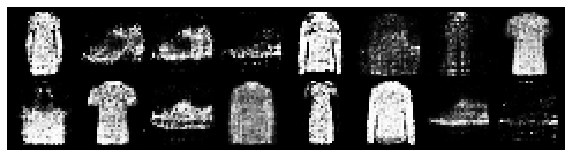

2020-04-30 20:54:38.496774 Epoch: [86/100], Batch Num: [0/64]
Discriminator Loss: 0.4823, Generator Loss: 0.3137
D(x): 0.5327, D(G(z)): 0.4690


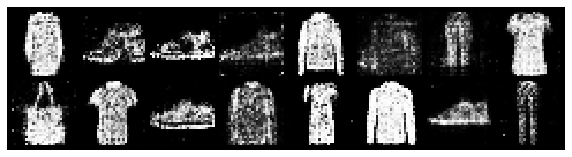

2020-04-30 20:55:02.109503 Epoch: [87/100], Batch Num: [0/64]
Discriminator Loss: 0.3615, Generator Loss: 0.4281
D(x): 0.6033, D(G(z)): 0.3712


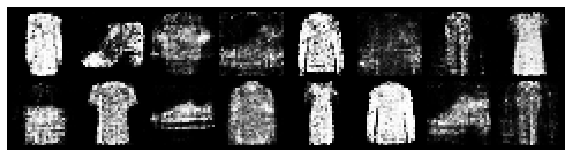

2020-04-30 20:55:26.951125 Epoch: [88/100], Batch Num: [0/64]
Discriminator Loss: 0.4630, Generator Loss: 0.3456
D(x): 0.5359, D(G(z)): 0.4057


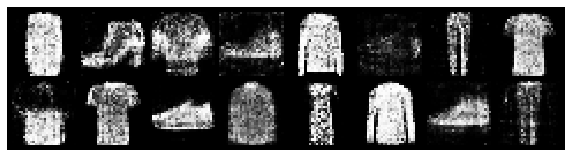

2020-04-30 20:55:50.702004 Epoch: [89/100], Batch Num: [0/64]
Discriminator Loss: 0.5399, Generator Loss: 0.3082
D(x): 0.5575, D(G(z)): 0.5019


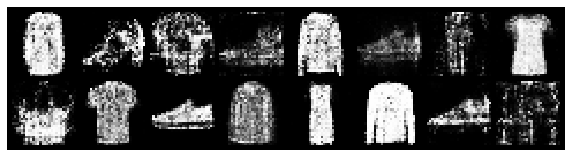

2020-04-30 20:56:14.379474 Epoch: [90/100], Batch Num: [0/64]
Discriminator Loss: 0.3788, Generator Loss: 0.4001
D(x): 0.6075, D(G(z)): 0.3955


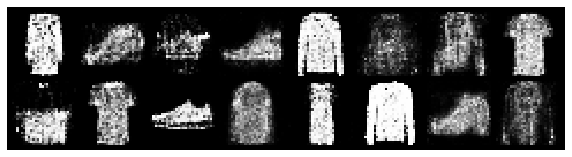

2020-04-30 20:56:38.138135 Epoch: [91/100], Batch Num: [0/64]
Discriminator Loss: 0.4422, Generator Loss: 0.4110
D(x): 0.5729, D(G(z)): 0.3918


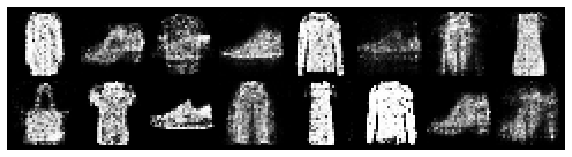

2020-04-30 20:57:01.685521 Epoch: [92/100], Batch Num: [0/64]
Discriminator Loss: 0.4530, Generator Loss: 0.3251
D(x): 0.6105, D(G(z)): 0.4872


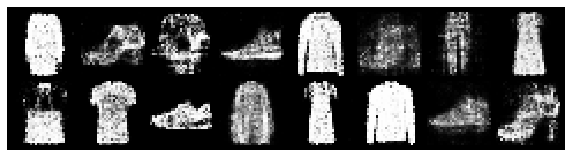

2020-04-30 20:57:25.195799 Epoch: [93/100], Batch Num: [0/64]
Discriminator Loss: 0.5119, Generator Loss: 0.3868
D(x): 0.5548, D(G(z)): 0.4288


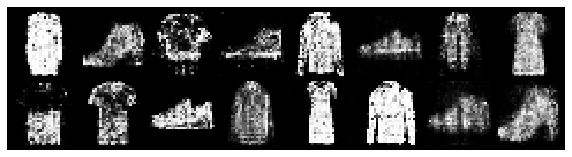

2020-04-30 20:57:48.712457 Epoch: [94/100], Batch Num: [0/64]
Discriminator Loss: 0.4426, Generator Loss: 0.3095
D(x): 0.5329, D(G(z)): 0.3828


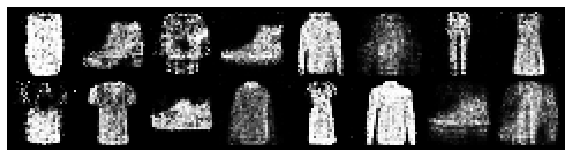

2020-04-30 21:08:03.326612 Epoch: [95/100], Batch Num: [0/64]
Discriminator Loss: 0.5115, Generator Loss: 0.3573
D(x): 0.4899, D(G(z)): 0.4506


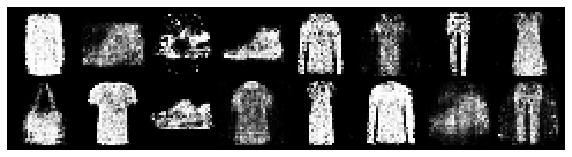

2020-04-30 21:08:28.631889 Epoch: [96/100], Batch Num: [0/64]
Discriminator Loss: 0.3937, Generator Loss: 0.3962
D(x): 0.6352, D(G(z)): 0.3997


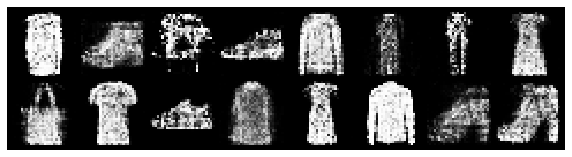

2020-04-30 21:08:53.888763 Epoch: [97/100], Batch Num: [0/64]
Discriminator Loss: 0.4086, Generator Loss: 0.3433
D(x): 0.6171, D(G(z)): 0.4218


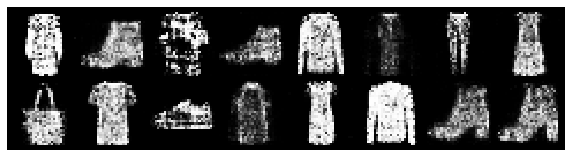

2020-04-30 21:09:18.622127 Epoch: [98/100], Batch Num: [0/64]
Discriminator Loss: 0.4634, Generator Loss: 0.3435
D(x): 0.5424, D(G(z)): 0.4327


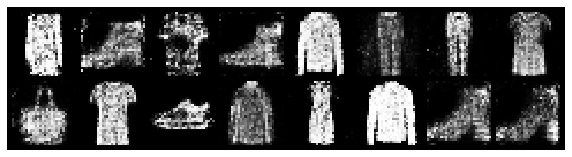

2020-04-30 21:09:43.400566 Epoch: [99/100], Batch Num: [0/64]
Discriminator Loss: 0.5269, Generator Loss: 0.2854
D(x): 0.4795, D(G(z)): 0.4406


In [23]:
logger = Logger(model_name='LSGAN', data_name='FA-MNIST00')
num_epochs=100
for epoch in range(num_epochs):
    
    D_losses = []
    G_losses = []
    for n_batch, (real_batch,_) in enumerate(data_loader):

        # 1. Train Discriminator
        real_data = Variable(images_to_vectors(real_batch))
        if torch.cuda.is_available(): real_data = real_data.cuda()
        # Generate fake data
        fake_data = generator(noise(real_data.size(0))).detach()
        # Train D
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer,
                                                                real_data, fake_data)
        D_losses.append(d_error)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(real_batch.size(0)))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        G_losses.append(g_error)
         # Display Progress
        if (n_batch) % 1000 == 0:
            #display.clear_output(True)
            # Display Images
            test_images = vectors_to_images(generator(test_noise)).data.cpu()
            logger.log_images(test_images, num_test_samples, epoch, n_batch, num_batches);
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )

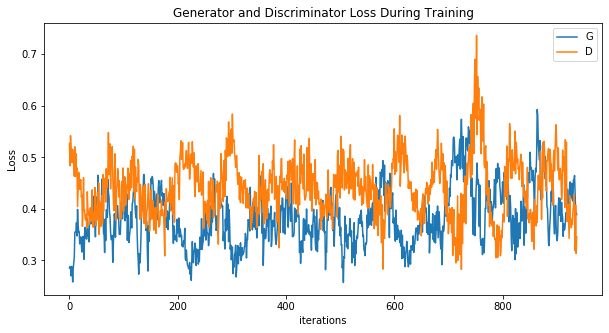

In [24]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [13]:
#https://github.com/diegoalejogm/gans/blob/master/utils.py
import os
import numpy as np
import errno
import torchvision.utils as vutils
from torch.utils.tensorboard import SummaryWriter
from IPython import display
from matplotlib import pyplot as plt
import torch
import datetime
'''
    TensorBoard Data will be stored in './runs' path
'''
class Logger:

    def __init__(self, model_name, data_name):

        self.model_name = model_name
        self.data_name = data_name
        self.comment = '{}_{}'.format(model_name, data_name)
        self.data_subdir = '{}/{}'.format(model_name, data_name)
        # TensorBoard
        self.writer = SummaryWriter(comment=self.comment)

    def log(self, d_error, g_error, epoch, n_batch, num_batches):
        # var_class = torch.autograd.variable.Variable
        if isinstance(d_error, torch.autograd.Variable):
            d_error = d_error.data.cpu().numpy()
        if isinstance(g_error, torch.autograd.Variable):
            g_error = g_error.data.cpu().numpy()

        step = Logger._step(epoch, n_batch, num_batches)
        self.writer.add_scalar(

            '{}/D_error'.format(self.comment), d_error, step)

        self.writer.add_scalar(

            '{}/G_error'.format(self.comment), g_error, step)

    def log_images(self, images, num_images, epoch, n_batch, num_batches, format='NCHW', normalize=True):

        '''
        input images are expected in format (NCHW)
        '''
        if type(images) == np.ndarray:

            images = torch.from_numpy(images)

        if format=='NHWC':

            images = images.transpose(1,3)
    
        step = Logger._step(epoch, n_batch, num_batches)

        img_name = '{}/images{}'.format(self.comment, '')

        # Make horizontal grid from image tensor

        horizontal_grid = vutils.make_grid(

            images, normalize=normalize, scale_each=True)

        # Make vertical grid from image tensor

        nrows = int(np.sqrt(num_images))

        grid = vutils.make_grid(

            images, nrow=nrows, normalize=True, scale_each=True)

        # Add horizontal images to tensorboard

        self.writer.add_image(img_name, horizontal_grid, step)

        # Save plots

        self.save_torch_images(horizontal_grid, grid, epoch, n_batch)

    def save_torch_images(self, horizontal_grid, grid, epoch, n_batch, plot_horizontal=True):

        out_dir = './data/images/{}'.format(self.data_subdir)

        Logger._make_dir(out_dir)

        # Plot and save horizontal

        fig = plt.figure(figsize=(10, 10))

        plt.imshow(np.moveaxis(horizontal_grid.numpy(), 0, -1))

        plt.axis('off')

        if plot_horizontal:

            display.display(plt.gcf())

        self._save_images(fig, epoch, n_batch, 'hori')

        plt.close()

        # Save squared

        fig = plt.figure()

        plt.imshow(np.moveaxis(grid.numpy(), 0, -1))

        plt.axis('off')

        self._save_images(fig, epoch, n_batch)

        plt.close()

    def _save_images(self, fig, epoch, n_batch, comment=''):

        out_dir = './data/images/{}'.format(self.data_subdir)

        Logger._make_dir(out_dir)

        fig.savefig('{}/{}_epoch_{}_batch_{}.png'.format(out_dir,

                                                         comment, epoch, n_batch))
    def display_status(self, epoch, num_epochs, n_batch, num_batches, d_error, g_error, d_pred_real, d_pred_fake):

        # var_class = torch.autograd.variable.Variable

        if isinstance(d_error, torch.autograd.Variable):

            d_error = d_error.data.cpu().numpy()

        if isinstance(g_error, torch.autograd.Variable):

            g_error = g_error.data.cpu().numpy()

        if isinstance(d_pred_real, torch.autograd.Variable):

            d_pred_real = d_pred_real.data

        if isinstance(d_pred_fake, torch.autograd.Variable):

            d_pred_fake = d_pred_fake.data

        
        print(datetime.datetime.now(), 'Epoch: [{}/{}], Batch Num: [{}/{}]'.format(

            epoch,num_epochs, n_batch, num_batches)

             )

        print('Discriminator Loss: {:.4f}, Generator Loss: {:.4f}'.format(d_error, g_error))

        print('D(x): {:.4f}, D(G(z)): {:.4f}'.format(d_pred_real.mean(), d_pred_fake.mean()))

    def save_models(self, generator, discriminator, epoch):

        out_dir = './data/models/{}'.format(self.data_subdir)

        Logger._make_dir(out_dir)

        torch.save(generator.state_dict(),

                   '{}/G_epoch_{}'.format(out_dir, epoch))

        torch.save(discriminator.state_dict(),

                   '{}/D_epoch_{}'.format(out_dir, epoch))

    def close(self):

        self.writer.close()

    # Private Functionality

    @staticmethod

    def _step(epoch, n_batch, num_batches):

        return epoch * num_batches + n_batch

    @staticmethod

    def _make_dir(directory):

        try:

            os.makedirs(directory)

        except OSError as e:

            if e.errno != errno.EEXIST:

                raise